In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mc
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from pandas.plotting import scatter_matrix
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree
from sklearn.neural_network import MLPRegressor
from joblib import dump
%matplotlib inline
from sklearn.metrics import mean_squared_error
np.random.seed(42)
from sklearn import neighbors
from math import sqrt

In [61]:
from pathlib import Path
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/My Drive')
gdrive_path = os.getcwd()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [62]:
path = Path.cwd() / "FOM_MA" / "data" / "train_set.csv"

In [ ]:
## Data understanding

In [80]:
train_df = pd.read_csv(path)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (20) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [81]:
## Data preparation
#deleting the columns 'Row_ID','Household_ID' from the dataframe as it is a unique and does not have any effect on the algorithm
del train_df['Row_ID']
del train_df['Household_ID']
df_amount_0 = train_df[ train_df['Claim_Amount'] == 0 ] 
train_df= train_df.drop(df_amount_0.index, axis=0) 

train_df = train_df.replace('?', np.nan)
train_df = train_df.dropna()

train_df.reset_index() 
train_df.index =range(len(train_df))

n = 7000#number of rows from the dataframe
train_data_points = 1000 # number of training data points


In [82]:
train_df.sample(5)

,Vehicle,Calendar_Year,Model_Year,Blind_Make,Blind_Model,Blind_Submodel,Cat1,Cat2,Cat3,Cat4,Cat5,Cat6,Cat7,Cat8,Cat9,Cat10,Cat11,Cat12,OrdCat,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,NVCat,NVVar1,NVVar2,NVVar3,NVVar4,Claim_Amount
27121,1,2005,2001,BH,BH.18,BH.18.5,B,C,F,A,A,B,C,A,B,B,B,C,2,-0.665897,-0.816152,-0.823407,-0.749192,-0.198358,-0.650165,-0.861623,-0.527934,M,-0.23153,-0.266117,-0.272337,-0.251419,0.903023
5591,3,2006,2005,K,K.7,K.7.3,B,C,B,A,A,B,C,B,A,A,B,B,2,-0.392708,-0.522203,-0.314319,-0.529313,-0.115098,-0.560097,-0.542145,-0.384300,N,-0.23153,-0.266117,-0.272337,-0.251419,63.811710
2291,1,2007,2004,BP,BP.6,BP.6.0,B,A,B,A,A,B,C,A,B,C,A,D,2,-0.456988,-0.850734,-0.129197,-0.901415,-0.317301,-0.360076,-0.886198,-0.650127,L,-0.23153,4.308482,-0.272337,-0.251419,85.690900
1689,2,2007,1999,BU,BU.38,BU.38.3,F,A,A,C,A,B,B,A,B,B,A,C,4,-0.481093,-0.332000,-0.453161,-0.394004,0.087105,-0.272348,-0.972211,0.290987,L,-0.23153,-0.266117,4.209404,-0.251419,0.502094
19360,1,2006,2005,X,X.24,X.24.9,B,C,A,A,A,C,C,A,B,B,F,C,2,-0.730177,-0.989063,-1.239933,-0.935242,-0.947698,-1.040848,-0.726459,-0.725062,O,-0.23153,-0.266117,-0.272337,-0.251419,3.248778


In [83]:
#creating 2 seperate dataframes for categorical and continuous features.
train_df_cat = pd.DataFrame()#training data frame with categorical features
train_df_cont = pd.DataFrame() #training data with continuous features
cat_list = []#list of categorical features
cont_list = []#list of continuous features

#populating the created data frames for categorical and continuous features
for each_column in train_df.columns:
    if train_df[each_column].dtype == 'float':
        cont_list.append(each_column)
cont_list.remove('Claim_Amount')
for each_column in train_df.columns:
    if train_df[each_column].dtype == 'object':
        cat_list.append(each_column)

for i in range(0,len(cat_list)):
    train_df_cat[i] = train_df[cat_list[i]]
train_df_cat.columns =cat_list
for i in range(0,len(cont_list)):
    train_df_cont[i] = train_df[cont_list[i]]
train_df_cont.columns =cont_list

In [84]:

#checking for missing values:
print ("The total missing values in data",train_df.isnull().sum().sum())
#sum is 0 which indicates there are no misisng values in the training data.

The total missing values in data 0


In [85]:
feature_list = []

train_df_best_features = pd.DataFrame()
for each_column in train_df.columns:
    if train_df[each_column].dtype == 'float':
        feature_list.append(each_column)

best_features_train_df = pd.DataFrame()
for i in range(0,len(feature_list)):
    best_features_train_df[i] = train_df[feature_list[i] ]
best_features_train_df.columns =feature_list
print(best_features_train_df.shape)

(28079, 13)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ConvergenceWarning: Number of distinct clusters (12) found smaller than n_clusters (13). Possibly due to duplicate points in X.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ConvergenceWarning: Number of distinct clusters (15) found smaller than n_clusters (16). Possibly due to duplicate points in X.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (9). Possibly

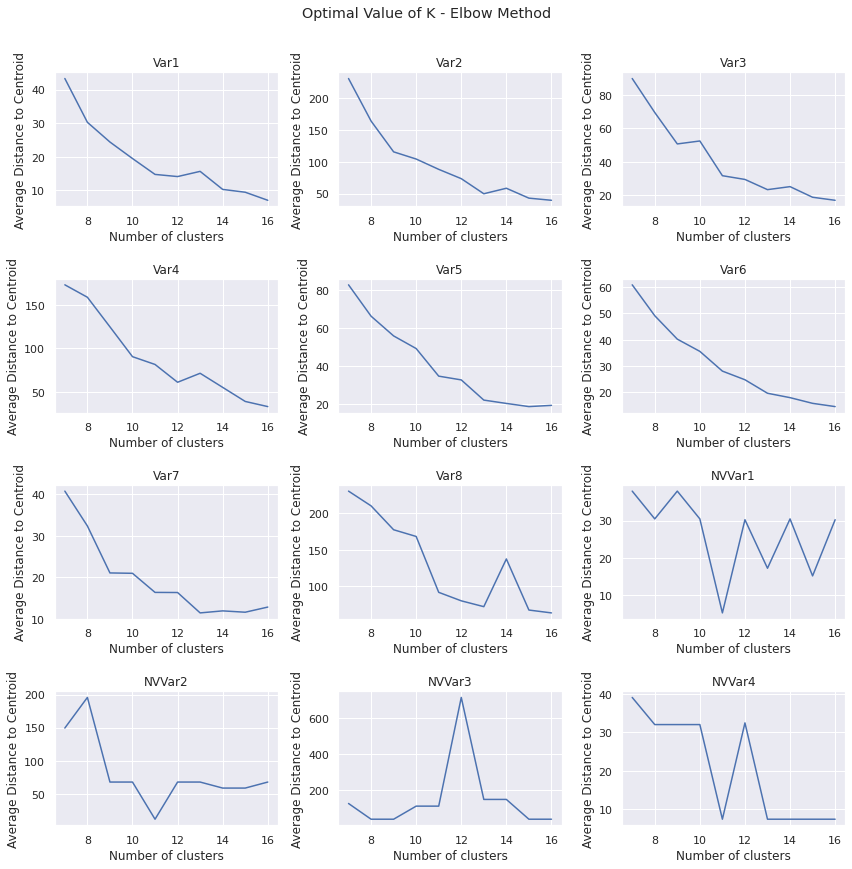

(7000, 12)


In [86]:
best_features_train_df =  best_features_train_df[:n]#nused
del best_features_train_df['Claim_Amount']
#using elbows method to find the optimal value of k
from sklearn.cluster import KMeans,MiniBatchKMeans
from scipy.spatial.distance import cdist,pdist

count = 1
plt.figure(figsize = (12,14))
for each_column in best_features_train_df.columns:
    range_to_be_tested = range(7,17)
    feature_reconfigured = best_features_train_df[each_column].values.reshape(-1, 1)

    model_fit = [KMeans(n_clusters = n,init = 'random',n_init=10).fit(feature_reconfigured) for n in range_to_be_tested]
    cluster_centers = [each_model.cluster_centers_ for each_model in model_fit]
    #print (len(cluster_centers))
    #print (cluster_centers)
    euc_distance = [cdist(feature_reconfigured,each_center,'euclidean') for each_center in cluster_centers]   
    min_distance = [np.min(each_distance,axis = 1) for each_distance in euc_distance]
    #Calcuating the total sum of squares (SSE):

    tsse = sum(pdist(feature_reconfigured)**2)/feature_reconfigured.shape[0]
    #print ("tsse",tsse)
    #print (kmeans_optimal.inertia_)
    #calculating the sse between the clusters:
    wsse = [sum (eac_dist **2) for eac_dist in min_distance]
    bsse = tsse - wsse
    #print (wsse)
    y_axis = wsse  #bsse/tsse
    #print (bsse)
    #print (bsse/tsse)
    cluster_variance_dict = dict(zip(range(7,17),y_axis))
    #print ("The dictionary with number of clusters as key and the variance as value",cluster_variance_dict)
    
    plt.subplot(5, 3, count)
    count += 1
    plt.plot(range(7,17),y_axis)
    plt.xlabel('Number of clusters')
    plt.ylabel('Average Distance to Centroid')
    plt.title(each_column)
plt.suptitle('Optimal Value of K - Elbow Method', y = 1.03)
plt.tight_layout()
#plt.savefig("/Users/vigneshsureshbabu/Documents/AML/Kaggle/alstate/figs/kmeans.png")
plt.show()

#On analysing in all the 14 continuous features the variance stabilizes at 13 or 14 clusters. It makes sense because all 
#continuous features has values in the similar range. Hence choosing 13 clusters.

#In this case we also considered the effect of choosing initial centroids. By setting the parameter n_init = 10,
#each feature is clustered with 10 different value of initial centroids for each value of k, and the initial seed with 
#minimum sse is chosen.

print(best_features_train_df.shape)

In [87]:
#Now that we have decided the optimal number of clusters for each feature, lets discretize the features.

from sklearn.cluster import KMeans,MiniBatchKMeans

print ("Before Clustring:")
print (best_features_train_df.head())

for each_column in best_features_train_df.columns:
    if each_column == 'Var4' or each_column == 'Var6' or each_column == 'NVVar2' :
        ftre = best_features_train_df[each_column].values.reshape(-1, 1)
        kmeans = KMeans(n_clusters = 10,init = 'random',n_init=20)
        model = kmeans.fit(ftre)   
        best_features_train_df[each_column] = kmeans.labels_
    elif each_column == 'Var1' or each_column == 'Var2'  or each_column == 'Var3'or each_column == 'Var5' or each_column == 'Var7'or each_column == 'Var8' or each_column == 'NVVar3'or each_column == 'NVVar4':  
        ftre = best_features_train_df[each_column].values.reshape(-1, 1)
        kmeans = KMeans(n_clusters = 8,init = 'random',n_init=20)
        model = kmeans.fit(ftre)   
        best_features_train_df[each_column] = kmeans.labels_   
    elif each_column == 'NVVar1':  
        ftre = best_features_train_df[each_column].values.reshape(-1, 1)
        kmeans = KMeans(n_clusters = 11,init = 'random',n_init=20)
        model = kmeans.fit(ftre)   
        best_features_train_df[each_column] = kmeans.labels_      
    

#print (best_features_train_df.head())
print ('\t')
print ("After Clustring:")
print (best_features_train_df.head())

Before Clustring:
       Var1      Var2      Var3  ...    NVVar2    NVVar3    NVVar4
0 -0.665897 -0.816152 -0.823407  ...  2.783616  2.715490 -0.251419
1  0.017076  1.777519 -0.013495  ... -0.266117  2.715490 -0.251419
2 -0.730177 -0.989063 -1.239933  ... -0.266117 -0.272337  1.408637
3 -0.320393 -0.643240 -0.337460  ... -0.266117 -0.272337 -0.251419
4 -0.738212 -1.127392 -1.147371  ...  2.783616 -0.272337 -0.251419

[5 rows x 12 columns]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (11). Possibly due to duplicate points in X.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  if sys.path[0] == '':


	
After Clustring:
   Var1  Var2  Var3  Var4  Var5  ...  Var8  NVVar1  NVVar2  NVVar3  NVVar4
0     0     1     6     0     2  ...     6       0       2       2       1
1     3     7     3     5     7  ...     3       0       0       2       1
2     0     0     1     9     4  ...     5       0       0       1       5
3     4     1     4     0     2  ...     6       0       0       1       1
4     0     0     1     9     4  ...     5       0       2       1       1

[5 rows x 12 columns]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (8). Possibly due to duplicate points in X.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (8). Possibly due to duplicate points in X.


In [88]:
best_features_train_df = best_features_train_df.astype('str')
column_list = best_features_train_df.columns
#print (best_features_train_df.shape)

train_df_cat_reduced = train_df_cat[:n] #nused
#Here will be the code to merge the clustered data frames after one hot encoding.

print ("Before Binarization:")
print ('\t')
print (train_df_cat_reduced.head())
for each_column in column_list:
    train_df_cat_reduced[each_column] = best_features_train_df[each_column]
    
#df_mod_onehotencoded will be the pre processed complete data including test and train
df_mod_onehotencoded = pd.get_dummies(train_df_cat_reduced)
df_mod_onehotencoded['Claim_Amount'] = train_df[:n]['Claim_Amount'] #nused
df_mod_onehotencoded = df_mod_onehotencoded.astype(int)

for index,each_row in df_mod_onehotencoded.iterrows():
    if each_row['Claim_Amount'] < 43.57:
        each_row['Claim_Amount'] = 0
    else:
         each_row['Claim_Amount'] = 1 #tobereplaced
df_mod_onehotencoded['Claim_Amount'] = df_mod_onehotencoded['Claim_Amount'].astype(int)
print ("After Binarization:")
print (df_mod_onehotencoded.head())

Before Binarization:
	
  Blind_Make Blind_Model Blind_Submodel Cat1  ... Cat11 Cat12 OrdCat NVCat
0         BH       BH.18        BH.18.5    B  ...     F     C      2     B
1          P        P.23         P.23.0    A  ...     A     C      5     N
2          X        X.24         X.24.9    B  ...     A     B      2     J
3         BU       BU.36        BU.36.2    B  ...     A     E      2     N
4         AR       AR.41        AR.41.3    B  ...     A     F      2     N

[5 rows x 17 columns]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


After Binarization:
   Blind_Make_AC  Blind_Make_AF  ...  NVVar4_6  Claim_Amount
0              0              0  ...         0             0
1              0              0  ...         0             0
2              0              0  ...         0             0
3              0              0  ...         0             0
4              0              0  ...         0             1

[5 rows x 816 columns]


The number of data points are:
{0: 3614, 1: 3386}


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


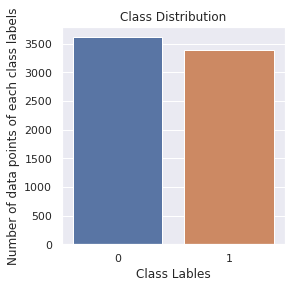

In [89]:

#We can see that the dataset is almost balanced
import seaborn as sns
y = df_mod_onehotencoded[['Cat1_A','Claim_Amount']].groupby("Claim_Amount").count().values.tolist()
x = df_mod_onehotencoded[['Cat1_A','Claim_Amount']].groupby("Claim_Amount").count().index.tolist()

for i in range(len(y)):
            y[i] = y[i][0]
print ("The number of data points are:")
print (dict(zip(x,y)))
%matplotlib inline
# plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
plt.figure(figsize = (4,4))
sns.set(font_scale =  1)
sns.barplot(x, y,label = "big")
plt.title("Class Distribution")
plt.xlabel('Class Lables')
plt.ylabel('Number of data points of each class labels')
#plt.savefig("/Users/vigneshsureshbabu/Documents/AML/Kaggle/alstate/figs/class_dist.png")
plt.show()

In [90]:
#Now that we have binarized the data using the one hot encoding, we have the data in the required format
#The next step is to apply feature selection and the machine learning algorithm

from sklearn.model_selection import train_test_split
#getting the target column into a seperate dataframe
target_df = pd.DataFrame()
target_df ['Claim_Amount'] = df_mod_onehotencoded['Claim_Amount']
#Hence deleting the target column from the features data frame
del df_mod_onehotencoded['Claim_Amount']
#splitting tha training data and testing data
# use train/test split with different random_state values
x_train, x_test, y_train, y_test = train_test_split(df_mod_onehotencoded, target_df, random_state=10)
#print (x_train.shape)
#print (y_train.shape)
#print (x_test.columns)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


The top features with CHI- Square Feature selection


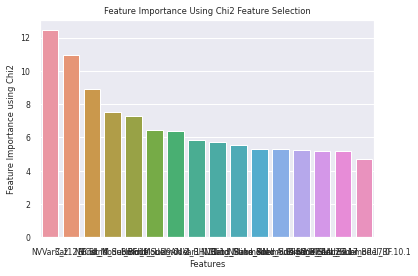

In [91]:
#Before applying the algorithm we will check the class balance in the data.
from math import isnan
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import seaborn as sns
chisqobj = SelectKBest(chi2, k=2)
fit = chisqobj.fit(x_train, y_train)
value_dict = dict(zip(df_mod_onehotencoded.columns,fit.scores_))
value_dict = {k: value_dict[k] for k in value_dict if not isnan(value_dict[k])}
sorted_important_features_list  = sorted(value_dict, key=value_dict.get,reverse = True)
#print (sorted_important_features_list)
#We have the list of the features, arranged in decsending order, i.e the feature with the maximum score will be the 
#first element in the list and so on.
#print (y_train.shape)
feature_list = [];feature_scores = [];
for i in range(0,16):
    feature_list.append(sorted_important_features_list[i])
    feature_scores.append(value_dict[sorted_important_features_list[i]])
%matplotlib inline
# plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
sns.set(font_scale =  .7)
sns.barplot(feature_list, feature_scores,label = "big")
print ("The top features with CHI- Square Feature selection")
plt.title("Feature Importance Using Chi2 Feature Selection")
plt.xlabel('Features')
plt.ylabel('Feature Importance using Chi2')
#plt.savefig('/Users/vigneshsureshbabu/Documents/AML/Kaggle/alstate/figs/chi2_ftre_imp.png')
plt.show()


#print (sorted_important_features_list)

The max accuracy for 100 top features 0.5203809523809524
The max accuracy for 200 top features 0.5139047619047619
The max accuracy for 300 top features 0.5226666666666666
The max accuracy for 400 top features 0.5163809523809524
The max accuracy for 500 top features 0.5106666666666666
The max accuracy for 600 top features 0.5045714285714286
The max accuracy for 700 top features 0.5009523809523809


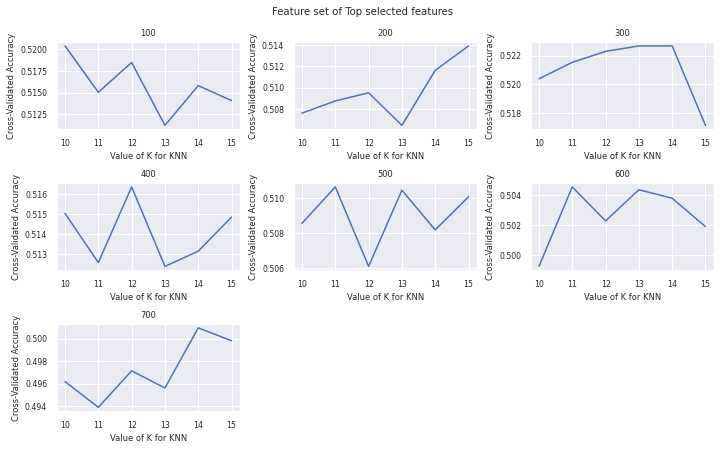

The top subset of features are: 300


In [92]:
#In the feature selection was not able to select the t - top features because, choosing k randomly might affect the 
#accuracy of the algorithm. We will now apply the k nn algorithm and select the optimal value of t(top features)
#and k (number of nearest neighbours using tuning set)

from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import  cross_val_score
ftre_list = [];score_list = [];
count = 1
plt.figure(figsize = (10,6))
for i in range(100,800,100):
    features = sorted_important_features_list[:i]
    #print ("here1")
    k_range = range(10, 16)
    k_scores = []
    for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k,weights='distance',algorithm='auto')      
        scores = cross_val_score(knn, x_train[features].values, y_train['Claim_Amount'].values, cv=10, scoring='accuracy')
        #print ("here2")
        k_scores.append(scores.mean())
        #print ("here3")
    print("The max accuracy for",i,"top features",max(k_scores))
    ftre_list.append(str(i))
    score_list.append(max(k_scores))
    #print ("here4")
    # plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
    plt.subplot(3, 3, count)
    count += 1
    plt.plot(k_range, k_scores)
    plt.xlabel('Value of K for KNN')
    plt.ylabel('Cross-Validated Accuracy')
    plt.title(i)
plt.suptitle('Feature set of Top selected features', y = 1.03)
plt.tight_layout()
#plt.savefig("/Users/vigneshsureshbabu/Documents/AML/Kaggle/alstate/figs/knn_optimal_finder.png")
plt.show()
ftre_select_dict = dict(zip(ftre_list,score_list))

selected_ftre_count = int (max(ftre_select_dict, key=ftre_select_dict.get))
print ("The top subset of features are:",selected_ftre_count)

The accuracy of the classifier is 52.34285714285715
The count of true negatives is C_{0,0}, false negatives is C_{1,0}, true positives is C_{1,1} and false positives is C_{0,1}
The confusion matrix for the classifier:
[[509 401]
 [433 407]]
The number of true negatives: 509
The number of false negatives: 433
The number of false positive: 401
The number of true positive: 407
The True Positive Rate for the Model: 0.4845238095238095
The False Positive Rate for the Model: 0.44065934065934065


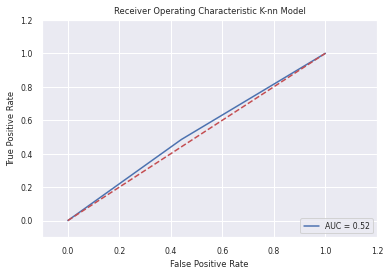

In [93]:
#Now that we have found the optimal number of features and value of k for the nearest neighbors using tuning set,
#lets apply the algorithm.

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
knn = KNeighborsClassifier(n_neighbors=13,weights = 'uniform')
knn.fit(x_train[sorted_important_features_list[0:selected_ftre_count]].values, y_train['Claim_Amount'].values)
y_pred_1 = knn.predict(x_test[sorted_important_features_list[0:selected_ftre_count]].values)
print("The accuracy of the classifier is",metrics.accuracy_score(y_test, y_pred_1)*100)

print ("The count of true negatives is C_{0,0}, false negatives is C_{1,0}, true positives is C_{1,1} and false positives is C_{0,1}")
print ("The confusion matrix for the classifier:")
confusion_matrix_1  =  confusion_matrix(y_test, y_pred_1)
print (confusion_matrix_1)

print ("The number of true negatives:",confusion_matrix_1[0][0])
print ("The number of false negatives:",confusion_matrix_1[1][0])
print ("The number of false positive:",confusion_matrix_1[0][1])
print ("The number of true positive:",confusion_matrix_1[1][1])
print ("The True Positive Rate for the Model:",(confusion_matrix_1[1][1])/(confusion_matrix_1[1][1] + confusion_matrix_1[1][0]))
print ("The False Positive Rate for the Model:",(confusion_matrix_1[0][1])/(confusion_matrix_1[0][1] + confusion_matrix_1[0][0]))


false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_1)
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.title('Receiver Operating Characteristic K-nn Model')
plt.plot(false_positive_rate, true_positive_rate, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#plt.savefig("/Users/vigneshsureshbabu/Documents/AML/Kaggle/alstate/figs/knn_roc.png")
plt.show()

The max accuracy for 100 top features 52.03809523809523
The max accuracy for 200 top features 51.942857142857136
The max accuracy for 300 top features 51.923809523809524
The max accuracy for 400 top features 51.96190476190476
The max accuracy for 500 top features 51.771428571428565
The max accuracy for 600 top features 51.86666666666666
The max accuracy for 700 top features 51.84761904761904


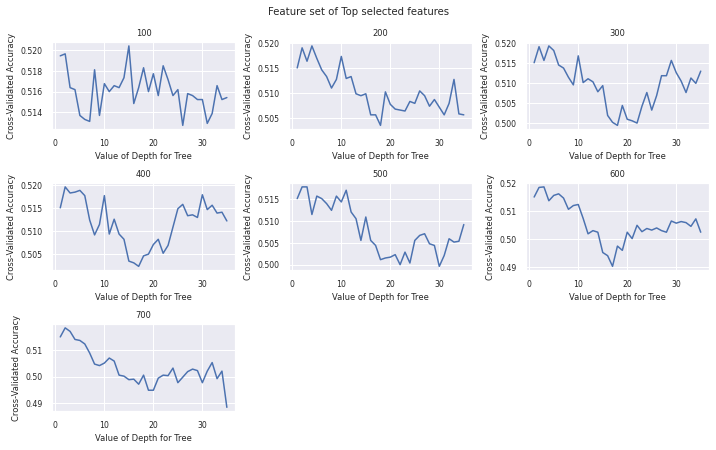

The top subset of features are: 100


In [94]:
from sklearn.tree import DecisionTreeClassifier
count = 1
plt.figure(figsize = (10,6))
dec_ftre_list = [];dec_score_list = [];
for i in range(100,800,100):
    #print ("here 2")
    features = sorted_important_features_list[:i]
    #print (features)
    k_range = range(1, 36)
    k_scores = []
    for k in k_range:
        tree = DecisionTreeClassifier(max_depth=k)
        scores = cross_val_score(tree, x_train[features].values, y_train['Claim_Amount'].values, cv=7, scoring='accuracy')
       
        k_scores.append(scores.mean())
    print("The max accuracy for",i,"top features",max(k_scores)*100)

    # plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
    dec_ftre_list.append(str(i))
    dec_score_list.append(max(k_scores))
    plt.subplot(3, 3, count)
    count += 1
    plt.plot(k_range, k_scores)
    plt.xlabel('Value of Depth for Tree')
    plt.ylabel('Cross-Validated Accuracy')
    plt.title(i)
plt.suptitle('Feature set of Top selected features', y = 1.03)
plt.tight_layout()
#plt.savefig("/Users/vigneshsureshbabu/Documents/AML/Kaggle/alstate/figs/depth_tuning_graph.png")
plt.show()

sel_count_dict = dict(zip(dec_ftre_list,dec_score_list))
sel_count = int (max(sel_count_dict, key=sel_count_dict.get))
print ("The top subset of features are:",sel_count)

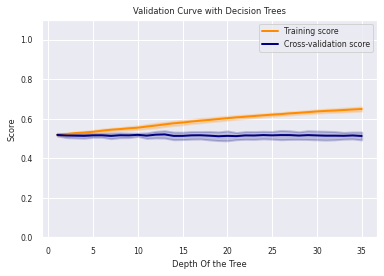

In [97]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import validation_curve

X, y = x_train[sorted_important_features_list[0:sel_count]].values, y_train['Claim_Amount'].values
param_range = range(1,36)
train_scores, test_scores = validation_curve(
    DecisionTreeClassifier(), X, y, param_name="max_depth", param_range=param_range,cv=10, scoring="accuracy", n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with Decision Trees")
plt.xlabel("Depth Of the Tree")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.plot(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.plot(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
#plt.savefig("/Users/vigneshsureshbabu/Documents/AML/Kaggle/alstate/figs/dtrees_valid_curve.png")
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


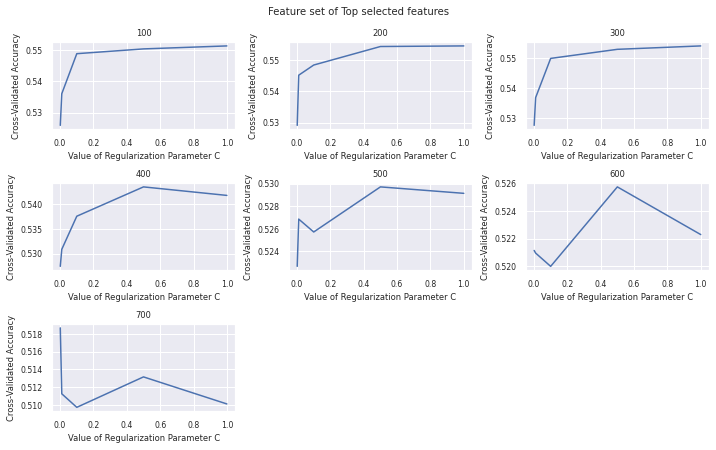

The top subset of features are: 200


In [101]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import  cross_val_score
from sklearn.metrics import confusion_matrix

count = 1
plt.figure(figsize = (10,6))
c_ftre_list = [];c_score_list = [];
for i in range(100,800,100):
    #print ("here 2")
    features = sorted_important_features_list[:i]
    #print (features)
    k_range = [0.001,0.01, 0.1,0.5, 1]
    k_scores = []
    for k in k_range:
        tree = LogisticRegression(penalty = 'l2', C = k)
        scores = cross_val_score(tree, x_train[features].values, y_train['Claim_Amount'].values, cv=10, scoring='accuracy')
        k_scores.append(scores.mean())
    #print("The max accuracy for",i,"top features",max(k_scores)*100)

    # plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
    c_ftre_list.append(str(i))
    c_score_list.append(max(k_scores))
    plt.subplot(3, 3, count)
    count += 1
    plt.plot(k_range, k_scores)
    plt.xlabel('Value of Regularization Parameter C')
    plt.ylabel('Cross-Validated Accuracy')
    plt.title(i)
plt.suptitle('Feature set of Top selected features', y = 1.03)
plt.tight_layout()
#plt.savefig("/Users/vigneshsureshbabu/Documents/AML/Kaggle/alstate/figs/logreg_c_tuning.png")
plt.show()
c_count_dict = dict(zip(c_ftre_list,c_score_list))
c_count = int (max(c_count_dict, key=c_count_dict.get))

print ("The top subset of features are:",c_count)

The accuracy of the classifier (LOGISTIC REGRESSION) is: 51.88571428571429
The count of true negatives is C_{0,0}, false negatives is C_{1,0}, true positives is C_{1,1} and false positives is C_{0,1}
The confusion matrix for the classifier:
[[494 416]
 [426 414]]
The True Positive Rate for the Model: 0.4928571428571429
The False Positive Rate for the Model: 0.45714285714285713
The number of true negatives: 494
The number of false negatives: 426
The number of false positive: 416
The number of true positive: 414


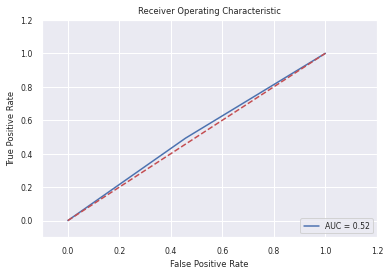

In [103]:
from sklearn.linear_model import LogisticRegression

from sklearn import metrics
tuned_logreg = LogisticRegression(penalty =  'l2',C =  0.01,class_weight = "balanced")

tuned_logreg.fit(x_train[sorted_important_features_list[0:c_count]].values, y_train['Claim_Amount'].values)
y_pred_3 = tuned_logreg.predict(x_test[sorted_important_features_list[0:c_count]].values)



print("The accuracy of the classifier (LOGISTIC REGRESSION) is:",metrics.accuracy_score(y_test, y_pred_3)*100)
print ("The count of true negatives is C_{0,0}, false negatives is C_{1,0}, true positives is C_{1,1} and false positives is C_{0,1}")
print ("The confusion matrix for the classifier:")
confusion_matrix_3 =  confusion_matrix(y_test, y_pred_3)
print (confusion_matrix_3)

print ("The True Positive Rate for the Model:",(confusion_matrix_3[1][1])/(confusion_matrix_3[1][1] + confusion_matrix_3[1][0]))
print ("The False Positive Rate for the Model:",(confusion_matrix_3[0][1])/(confusion_matrix_3[0][1] + confusion_matrix_3[0][0]))

print ("The number of true negatives:",confusion_matrix_3[0][0])
print ("The number of false negatives:",confusion_matrix_3[1][0])
print ("The number of false positive:",confusion_matrix_3[0][1])
print ("The number of true positive:",confusion_matrix_3[1][1])

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_3)
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#plt.savefig("/Users/vigneshsureshbabu/Documents/AML/Kaggle/alstate/figs/ROC_log_reg.png")
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


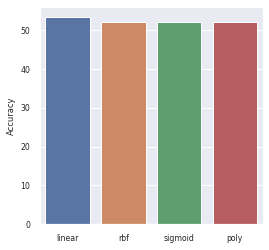

In [106]:
from sklearn import svm
svm_linear_count = 200
kernel_list = ['linear','rbf','sigmoid','poly']
svm_df = pd.DataFrame(columns = kernel_list,index=['Accuracy'])

for each_kernel in kernel_list:
    sup_nonlinear = svm.SVC( C = 0.01,kernel = each_kernel)
    sup_nonlinear.fit(x_train[sorted_important_features_list[0:svm_linear_count]].values, y_train['Claim_Amount'].values)
    y_pred_nonlinearsvm = sup_nonlinear.predict(x_test[sorted_important_features_list[0:svm_linear_count]].values)
    accuracy = metrics.accuracy_score(y_test, y_pred_nonlinearsvm)*100
    svm_df[each_kernel] = accuracy

    
plt.figure(figsize = (4,4))
sns.barplot(svm_df.columns, svm_df.loc['Accuracy'])
#plt.savefig("/Users/vigneshsureshbabu/Documents/AML/Kaggle/alstate/figs/svm_nonlinear_analysis.png")